# 28. Calculating Atomic Contributions for Molecules Based on a Graph Convolutional  QSAR Model

In an earlier tutorial we introduced the concept of model interpretability: understanding why a model produced the result it did.  In this tutorial we will learn about atomic contributions, a useful tool for interpreting models that operate on molecules.

The idea is simple: remove a single atom from the molecule and see how the model's prediction changes.  The "atomic contribution" for an atom is defined as the difference in activity between the whole molecule, and the fragment remaining after atom removal.  It is a measure of how much that atom affects the prediction.

Contributions are also known as "attributions", "coloration", etc. in the literature. This is a model interpretation method [1], analogous to Similarity maps [2] in the QSAR domain, or occlusion methods in other fields (image classification, etc).

Mariia Matveieva, Pavel Polishchuk. Institute of Molecular and Translational Medicine, Palacky University, Olomouc, Czech Republic.

<img src="atomic_contributions_tutorial_data/index.png">

## Colab

This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/28_Atomic_Contributions_for_Molecules.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following installation commands. This will take about 5 minutes to run to completion and install your environment. You can of course run this tutorial locally if you prefer. In that case, don't run these cells since they will download and install Anaconda on your local machine.

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

## A classification QSAR model for blood-brain barrier permeability

BBB permeability is the ability of compounds to enter the central nervous system. Here we use a dataset of relatively small compounds which are transported by diffusion without any carriers.  The property is defined as log10(concentration in brain / concentration in blood). Compounds with a positive value (and 0) are labeled active, and others are labeled inactive.  After modelling we will identify atoms favorable and unfavorable for diffusion.

First let's create the dataset.  The molecules are stored in an SDF file.

In [1]:
import pandas as pd
import deepchem as dc
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf

DATASET_FILE ='atomic_contributions_tutorial_data/logBB.sdf'
# Create RDKit mol objects, since we will need them later.
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]
loader = dc.data.SDFLoader(tasks=["logBB_class"], 
                           featurizer=dc.feat.ConvMolFeaturizer(),
                           sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=2000)

Now let's build and train a GraphConvModel.

In [2]:
np.random.seed(2020)
tf.random.set_seed(2020)

In [3]:
m = dc.models.GraphConvModel(1, mode="classification", batch_normalize=False, batch_size=100)
m.fit(dataset, nb_epoch=10)

0.5348200480143229

Let's load a test set and see how well it works.

In [4]:
TEST_DATASET_FILE = 'atomic_contributions_tutorial_data/logBB_test_.sdf'
loader = dc.data.SDFLoader(tasks=["p_np"], sanitize=True,
                           featurizer=dc.feat.ConvMolFeaturizer())
test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)
pred =  m.predict(test_dataset)
pred = np.argmax(np.squeeze(pred),axis=1)
ba = metrics.balanced_accuracy_score(y_true=test_dataset.y, y_pred=pred)
print(ba)

0.7444444444444445


The balanced accuracy is high enough.  Now let's proceed to model interpretation and estimate the contributions of individual atoms to the prediction.

## A fragment dataset

Now let's prepare a dataset of fragments based on the training set.  (Any other unseen data set of interest can also be used). These fragments will be used to evaluate the contributions of individual atoms.

For each molecule we will generate a list of ConvMol objects.  Specifying `per_atom_fragmentation=True` tells it to iterate over all heavy atoms and featurize a single-atom-depleted version of the  molecule with each one removed.

In [5]:
loader = dc.data.SDFLoader(tasks=[],# dont need task (moreover, passing the task can lead to inconsitencies in data shapes)
                        featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True),
                        sanitize=True) 
frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

The dataset still has the same number of samples as the original training set, but each sample is now represented as a list of ConvMol objects (one for each fragment) rather than a single ConvMol.

IMPORTANT: The order of fragments depends on the input format.  If SDF, the fragment order is the same as the atom order in corresponding mol blocks.  If SMILES (i.e. csv with molecules represented as SMILES), then the order is given by RDKit CanonicalRankAtoms

In [6]:
print(frag_dataset.X.shape)

(298,)


We really want to treat each fragment as a separate sample.  We can use a FlatteningTransformer to flatten the fragments lists.

In [7]:
tr = dc.trans.FlatteningTransformer(frag_dataset)
frag_dataset = tr.transform(frag_dataset)
print(frag_dataset.X.shape)

(5111,)


## Predicting atomic contributions to activity

Now we will predict the activity for molecules and for their fragments. Then, for each fragment, we'll find the activity difference: the change in activity when removing one atom.

Note: Here, in classification context, we use the probability output of the model as the activity. So the contribution is the probability difference, i.e. "how much a given atom increases/decreases the probability of the molecule being active."

In [8]:
# whole  molecules
pred = np.squeeze(m.predict(dataset))[:, 1] # probabilitiy of class 1
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convinience

# fragments
pred_frags = np.squeeze(m.predict(frag_dataset))[:, 1]
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])

We take the difference to find the atomic contributions.

In [9]:
# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

In [10]:
df

,Fragment,Molecule,Contrib
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.756531,0.811546,0.055015
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.752750,0.811546,0.058796
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.747007,0.811546,0.064539
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.815875,0.811546,-0.004329
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.741801,0.811546,0.069745
...,...,...,...
c1cncc(C2CCCN2)c1,0.780478,0.813036,0.032558
c1cncc(C2CCCN2)c1,0.722650,0.813036,0.090386
c1cncc(C2CCCN2)c1,0.721609,0.813036,0.091427
c1cncc(C2CCCN2)c1,0.683302,0.813036,0.129734


We can use the SimilarityMaps feature of RDKit to visualize the results.  Each atom is colored by how it affects activity.

In [11]:
def vis_contribs(mols, df, smi_or_sdf = "sdf"): 
    # input format of file, which was used to create dataset determines the order of atoms, 
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]
        if smi_or_sdf == "sdf":        
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps    

Let's look at some pictures:

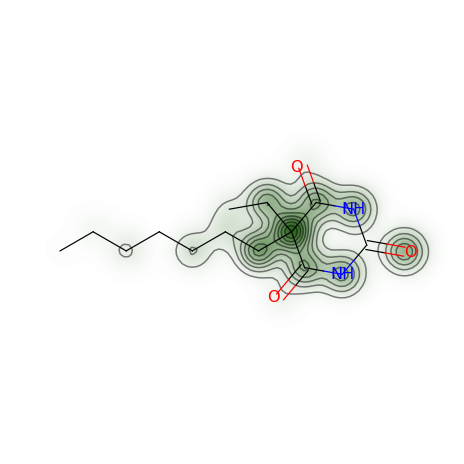

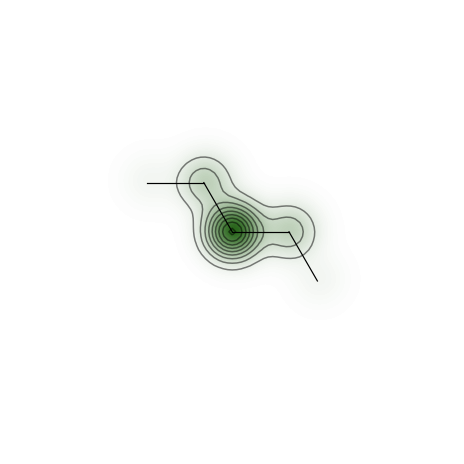

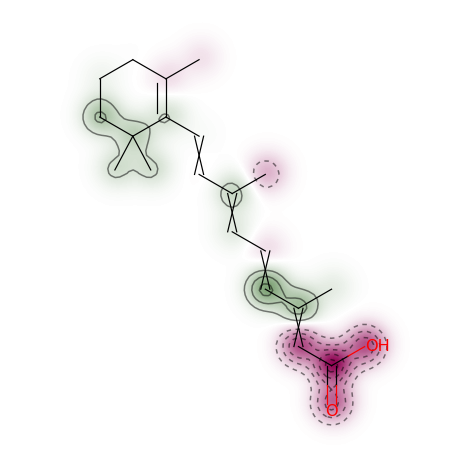

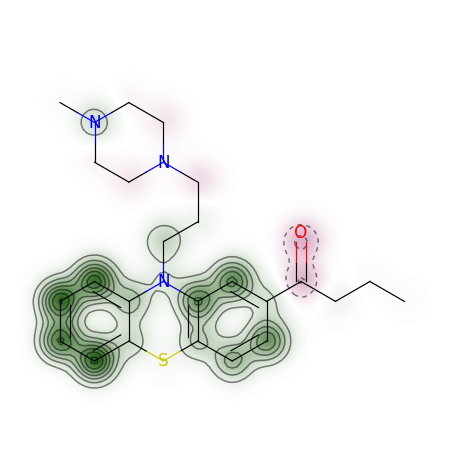

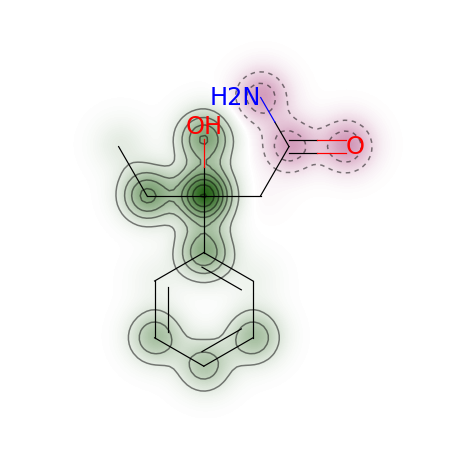

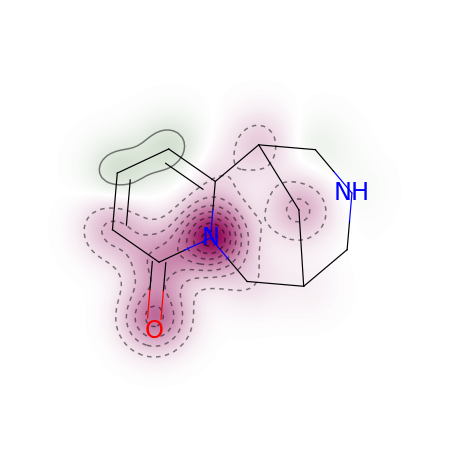

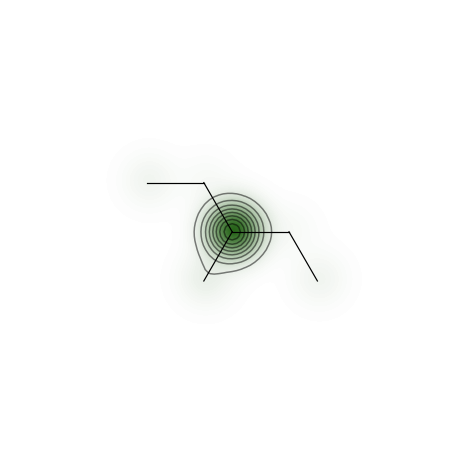

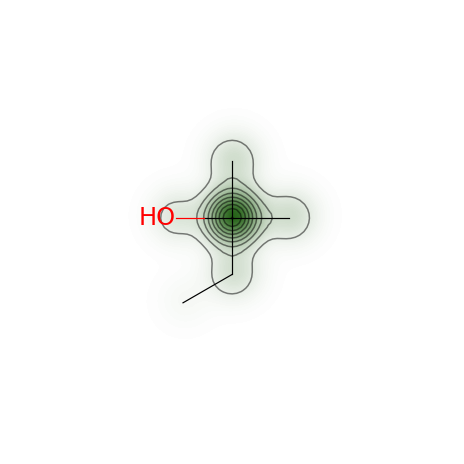

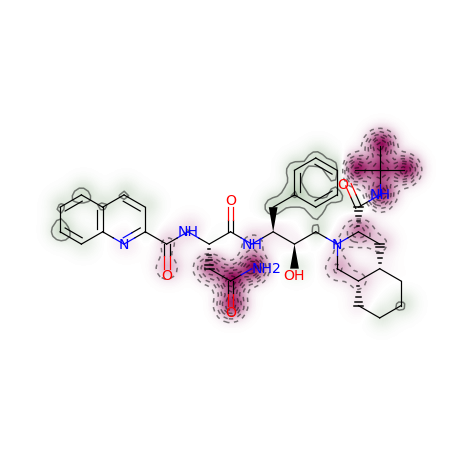

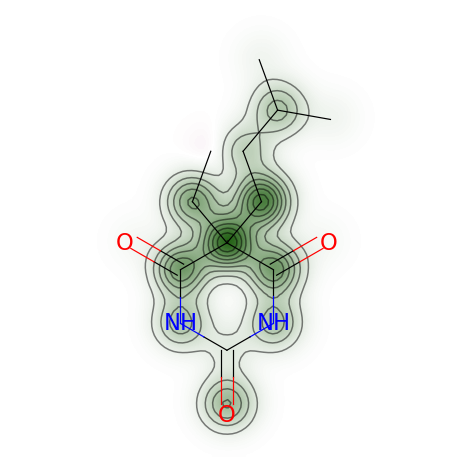

In [12]:
np.random.seed(2000)
maps = vis_contribs(np.random.choice(np.array(mols),10), df)

We can see that aromatics or aliphatics have a positive impact on blood-brain barrier permeability, while polar or charged heteroatoms have a negative influence. This is generally consistent with literature data.

## A regression task

The example above used a classification model.  The same techniques can also be used for regression models.  Let's look at a regression task, aquatic toxicity (towards the water organism T. pyriformis).

Toxicity is defined as log10(IGC50) (concentration that inhibits colony growth by 50%). Toxicophores for T. pyriformis will be identified by atomic contributions.

All the above steps are the same: load data, featurize, build a model, create dataset of fragments, find contributions, and visualize them.

Note: this time as it is regression, contributions will be in activity units, not probability.

In [13]:
DATASET_FILE ='atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Work_set_OCHEM.sdf'
# create RDKit mol objects, we will need them later
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]
loader = dc.data.SDFLoader(tasks=["IGC50"], 
                           featurizer=dc.feat.ConvMolFeaturizer(), sanitize=True)
dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

Create and train the model.

In [14]:
np.random.seed(2020)
tf.random.set_seed(2020)
m = dc.models.GraphConvModel(1, mode="regression", batch_normalize=False)
m.fit(dataset, nb_epoch=40)

0.11455048561096191

Load the test dataset and check the model's performance.

In [15]:
TEST_DATASET_FILE = 'atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Test_set_OCHEM.sdf'
loader = dc.data.SDFLoader(tasks=["IGC50"], sanitize= True,
                           featurizer=dc.feat.ConvMolFeaturizer())
test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)
pred = m.predict(test_dataset)
mse = metrics.mean_squared_error(y_true=test_dataset.y, y_pred=pred)
r2 = metrics.r2_score(y_true=test_dataset.y, y_pred=pred)
print(mse)
print(r2)

0.25099045657899444
0.7727331443498195


Load the training set again, but this time set `per_atom_fragmentation=True`.

In [16]:
loader = dc.data.SDFLoader(tasks=[], # dont need any task
                           sanitize=True,
                           featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True)) 
frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)
tr = dc.trans.FlatteningTransformer(frag_dataset) # flatten dataset and add ids to each fragment
frag_dataset = tr.transform(frag_dataset)

Compute the activity differences.

In [17]:
# whole molecules
pred = m.predict(dataset)
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convenience

# fragments
pred_frags = m.predict(frag_dataset)
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])  # turn to dataframe for convenience

# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

Lets take some molecules with moderate activity (not extremely active/inactive) and visualize the atomic contributions.

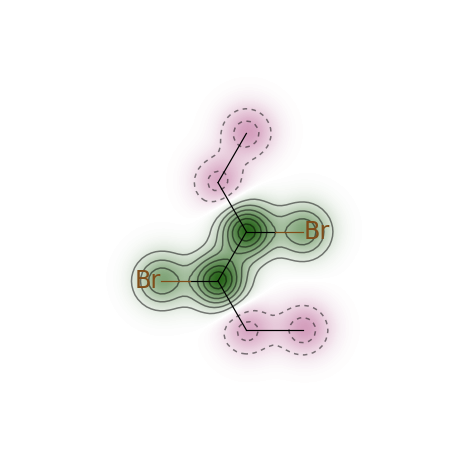

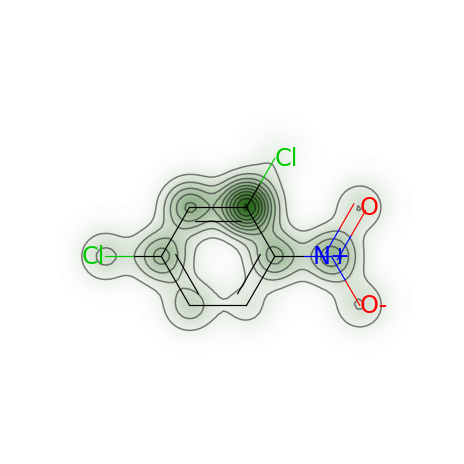

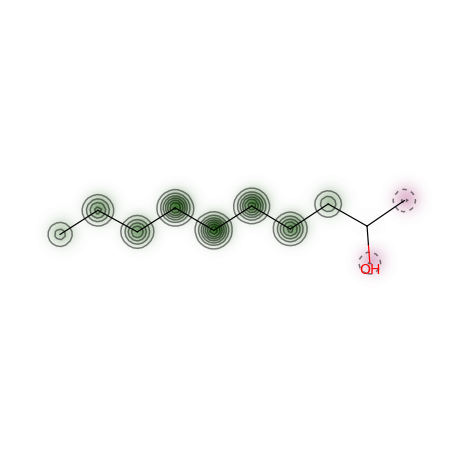

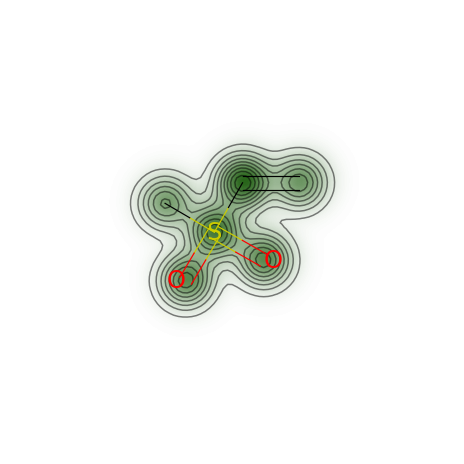

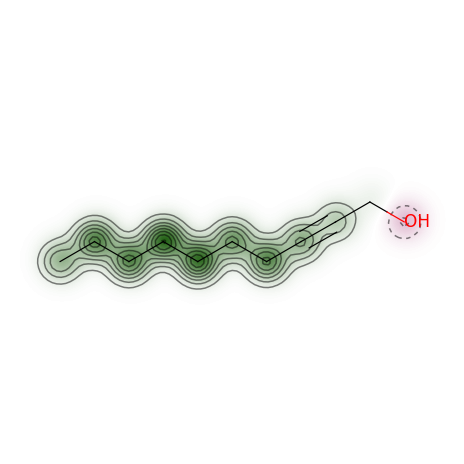

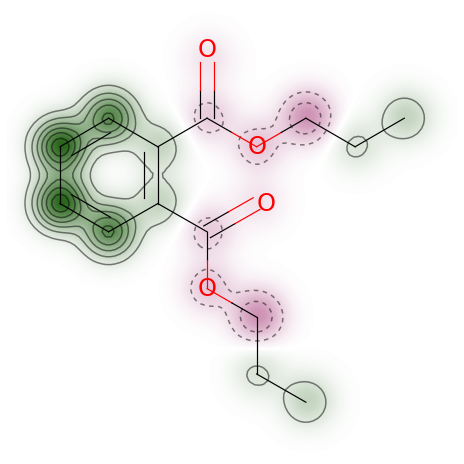

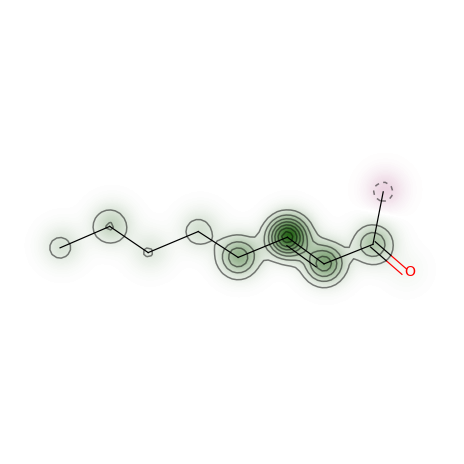

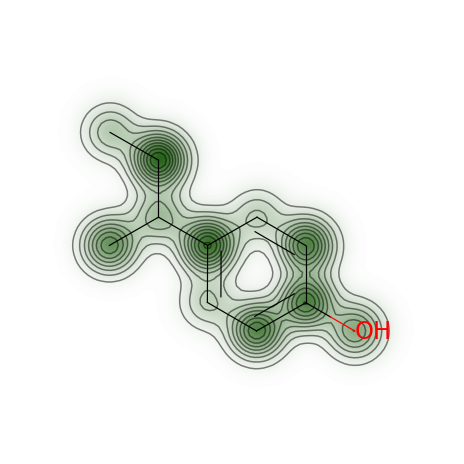

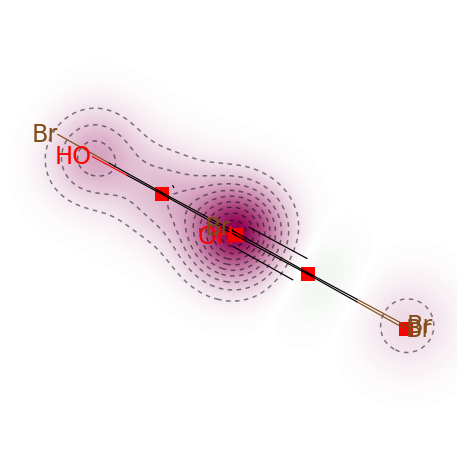

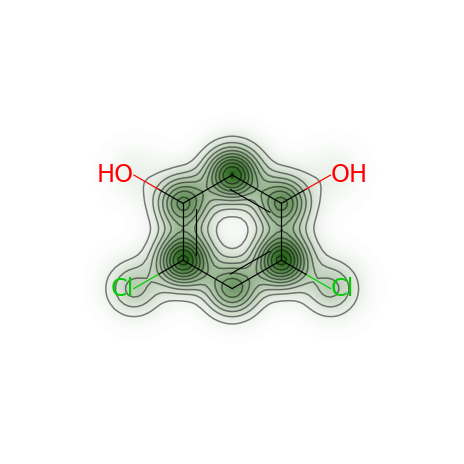

In [18]:
maps = vis_contribs([mol for mol in mols if float(mol.GetProp("IGC50"))>3 and float(mol.GetProp("IGC50"))<4][:10], df)

We can see that known toxicophores are in green, namely nitro-aromatics, halo-aromatics, long alkyl chains, and aldehyde; while carboxylic groups, alcohols, and aminos are detoxyfying, as is consistent with literature [3]

# Appendix

In this tutorial we operated on SDF files. However, if we use CSV files with SMILES as input, the order of the atoms in the dataframe DOES NOT correspond to the original atom order. If we want to recover the original atom order for each molecule (to have it in our main dataframe), we need to use RDKit's  Chem.rdmolfiles.CanonicalRankAtoms. Here are some utilities to do this.

We can add a column with atom ids (as in input molecules) and use the resulting dataframe for analysis with any other software, outside the "python-rdkit-deepchem" environment.

In [ ]:
def get_mapping(mols, mol_names): 
    """perform mapping:
    atom number original <-> atom number(position) 
    after ranking (both 1-based)"""
    # mols - RDKit mols
    # names  - any seq of strings
    # return list of nested lists: [[molecule, [atom , atom, ..], [...]]
    assert(len(mols)==len(mol_names))
    mapping = []
    for m,n in zip(mols, mol_names):
        atom_ids = [i+1 for i in list(Chem.rdmolfiles.CanonicalRankAtoms(m))]
        mapping.append([n, atom_ids])
    return mapping

In [ ]:
def append_atomid_col(df, mapping):
    # add column with CORRECT atom number(position)
    for i in mapping:
        df.loc[i[0],"AtomID"] = i[1]
    return df   

# Bibliography:

1. Polishchuk, P., O. Tinkov, T. Khristova, L. Ognichenko, A. Kosinskaya, A. Varnek & V. Kuz’min (2016) Structural and Physico-Chemical Interpretation (SPCI) of QSAR Models and Its Comparison with Matched Molecular Pair Analysis. Journal of Chemical Information and Modeling, 56, 1455-1469.

2. Riniker, S. & G. Landrum (2013) Similarity maps - a visualization strategy for molecular fingerprints and machine-learning methods. Journal of Cheminformatics, 5, 43.

3. M. Matveieva, M. T. D. Cronin, P. Polishchuk, Mol. Inf. 2019, 38, 1800084. 

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!